In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [25]:
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_dir = project_root / "data"

candidate_dirs = [
    data_dir,
    data_dir / "StockExchangeData",
]

def resolve_csv(filename: str) -> Path:
    for folder in candidate_dirs:
        candidate = folder / filename
        if candidate.exists():
            return candidate
    searched = "\n".join(str(folder / filename) for folder in candidate_dirs)
    raise FileNotFoundError(f"Could not find {filename}. Searched:\n{searched}")

index_processed_path = resolve_csv("indexData.csv")
index_info_path = resolve_csv("indexInfo.csv")
index_processed_path = resolve_csv("indexProcessed.csv")

In [26]:
index_processed = pd.read_csv(index_processed_path, parse_dates=[1])
print("index_processed shape:", index_processed.shape)

index_processed shape: (104224, 9)


In [27]:
index_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Index      104224 non-null  object        
 1   Date       104224 non-null  datetime64[ns]
 2   Open       104224 non-null  float64       
 3   High       104224 non-null  float64       
 4   Low        104224 non-null  float64       
 5   Close      104224 non-null  float64       
 6   Adj Close  104224 non-null  float64       
 7   Volume     104224 non-null  float64       
 8   CloseUSD   104224 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 7.2+ MB


In [28]:
index_processed.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [29]:
index_processed['Index'].unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

In [30]:
index_mask = index_processed['Index'] == 'NYA'
date_mask = index_processed['Date'] >= datetime.datetime(year=2004,month=1,day=1)
nya_df = index_processed[index_mask & date_mask].set_index('Date').drop(columns=['Index', 'CloseUSD'])
nya_df.shape 

(4382, 6)

In [31]:
nya_df.rename(columns={'Open':'Last Close', 'Adj Close': 'Last Adj Close'},inplace=True)
#align target (next day's close) with predictors
nya_df['Close'] = nya_df['Close'].shift(-1)
#align last adjust closing price with last closing price
nya_df['Last Adj Close'] = nya_df['Last Adj Close'].shift(1)
nya_df.dropna(inplace=True)

In [32]:
nya_df.shape

(4380, 6)

In [33]:
nya_df.head()

,Last Close,High,Low,Close,Last Adj Close,Volume
Date,,,,,,
2004-01-05,6451.259766,6534.759766,6451.259766,6541.149902,6451.259766,1.578200e+09
2004-01-06,6534.580078,6546.640137,6519.270020,6525.299805,6534.580078,1.494500e+09
2004-01-07,6541.149902,6541.209961,6488.270020,6569.319824,6541.149902,1.704900e+09
2004-01-08,6525.299805,6569.319824,6525.279785,6526.169922,6525.299805,1.868400e+09
2004-01-09,6569.319824,6569.319824,6517.120117,6543.680176,6569.319824,1.720700e+09


In [34]:
target = 'Close'
y = nya_df[target]
X = nya_df.drop(columns=[target])

In [35]:
X.head()

,Last Close,High,Low,Last Adj Close,Volume
Date,,,,,
2004-01-05,6451.259766,6534.759766,6451.259766,6451.259766,1.578200e+09
2004-01-06,6534.580078,6546.640137,6519.270020,6534.580078,1.494500e+09
2004-01-07,6541.149902,6541.209961,6488.270020,6541.149902,1.704900e+09
2004-01-08,6525.299805,6569.319824,6525.279785,6525.299805,1.868400e+09
2004-01-09,6569.319824,6569.319824,6517.120117,6569.319824,1.720700e+09


In [38]:
y.head()

Date
2004-01-05    6541.149902
2004-01-06    6525.299805
2004-01-07    6569.319824
2004-01-08    6526.169922
2004-01-09    6543.680176
Name: Close, dtype: float64

In [39]:
X['LowProportion'] = X['Low']/X['Last Close']
X['HighProportion'] = X['High']/X['Last Close']
#nya_df['CloseDiff'] = nya_df['Close'] - nya_df['Open']

In [40]:
X.drop(columns=['High', 'Low'], inplace=True)
X.head()

,Last Close,Last Adj Close,Volume,LowProportion,HighProportion
Date,,,,,
2004-01-05,6451.259766,6451.259766,1.578200e+09,1.000000,1.012943
2004-01-06,6534.580078,6534.580078,1.494500e+09,0.997657,1.001846
2004-01-07,6541.149902,6541.149902,1.704900e+09,0.991916,1.000009
2004-01-08,6525.299805,6525.299805,1.868400e+09,0.999997,1.006746
2004-01-09,6569.319824,6569.319824,1.720700e+09,0.992054,1.000000


,Last Close,Last Adj Close,Volume,LowProportion,HighProportion
Last Close,1.000,1.000,0.034,0.176,-0.226
Last Adj Close,1.000,1.000,0.034,0.177,-0.225
Volume,0.034,0.034,1.000,-0.414,0.349
LowProportion,0.176,0.177,-0.414,1.000,0.181
HighProportion,-0.226,-0.225,0.349,0.181,1.000


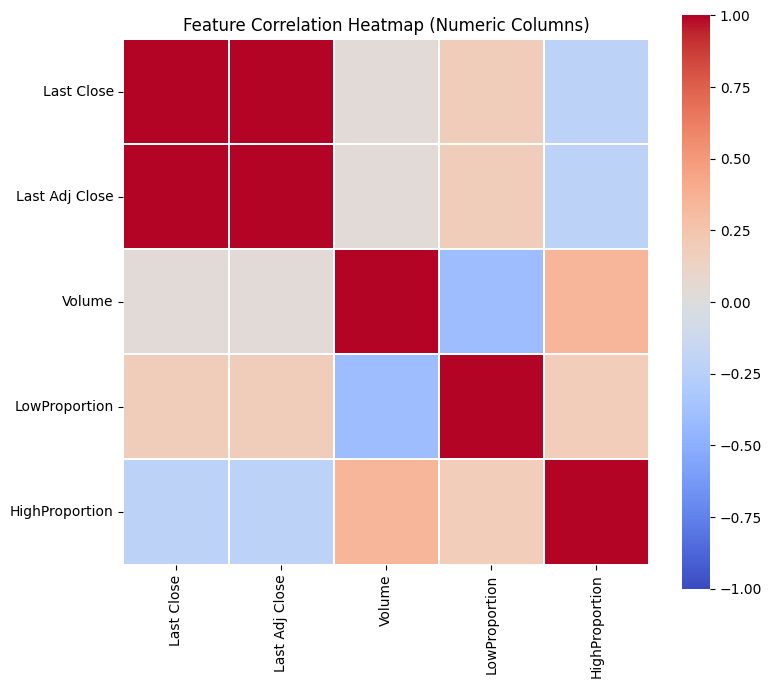

Top 10 strongest correlations (absolute):


correlation
Last Close     Last Adj Close     0.999769
Last Adj Close Last Close         0.999769
Volume         LowProportion     -0.413754
LowProportion  Volume            -0.413754
HighProportion Volume             0.348835
Volume         HighProportion     0.348835
Last Close     HighProportion    -0.225591
HighProportion Last Close        -0.225591
               Last Adj Close    -0.225479
Last Adj Close HighProportion    -0.225479

In [42]:
numeric_df = X.select_dtypes(include=[np.number]).copy()

if numeric_df.shape[1] < 2:
    print("Not enough numeric columns to compute correlation.")
else:
    corr_matrix = numeric_df.corr(numeric_only=True)
    display(corr_matrix.round(3))

    feature_count = corr_matrix.shape[0]
    fig_size = max(8, min(18, int(feature_count * 0.8)))

    plt.figure(figsize=(fig_size, fig_size))
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.3,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Feature Correlation Heatmap (Numeric Columns)")
    plt.tight_layout()
    plt.show()

    corr_pairs = (
        corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))
        .stack()
        .sort_values(key=lambda s: s.abs(), ascending=False)
    )
    print("Top 10 strongest correlations (absolute):")
    display(corr_pairs.head(10).to_frame("correlation"))